# Recognizing hand-written digits
### Deep-learning with keras on tensorflow

Documentation for `keras` can be found at https://keras.io/.

Keras is a frontend wrapper or api for tensorflow, theano or cntk. It also requires scipy to be installed. While most of the required libraries can be installed through `pip` on Windows, `scipy` needs to be loaded from prebuilt binaries using a wheel. There is an unofficial repository at http://www.lfd.uci.edu/~gohlke/pythonlibs/.

I decided to use the cpu only version of `tensorflow` as the backend in a python3.6 64-bit environment (Windows 10)
 - prebuilt binary for numpy with MKL
 - prebuilt binary for scipy
 - `pip install --upgrade tensorflow`
 - `pip install <downloaded numpy wheel>
 - `pip install <downloaded scipy wheel>`
 - `pip install --upgrade keras`

When you try to load `keras` the very first time, it creates a config file (keras.json) in the .keras folder in %USERPROFILE%. On Windows 8+ platforms, this should be C:\Users\<yourname>. The "backend" key needs to be set to `tensorflow`.

If we were planning to use this for working with images, we may need some additional libraries.

In this notebook, I am going to walk through a series of analyses that touches on several techniques researchers have used to improve the accuracy of recognizing handwritten digits from the MNIST dataset.


In [2]:
import tensorflow as tf
print("Loaded tensorflow")
try:
    import keras
    print("Loaded keras")
except ImportError as e:
    print("Could not import keras: {}".format(e))

import pandas as pd
import numpy as np
print("Completed loading all libraries")
# WARNING (theano.configdefaults): g++ not detected !

Loaded tensorflow
Loaded keras
Completed loading all libraries


In [18]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score


In [15]:
LOCAL_DATASET = "C:/Users/Zeta/Documents/Kaggle/MNIST digits 2016"

def load_data():
    # read data from local files and return it in the same format asa keras dataset
    df = pd.read_csv('train.csv' )
    X = train_test_split(df.drop('label', axis=1), \
                                                      df.label, \
                                                      test_size=0.30, \
                                                      random_state=10 )
    return [X[i].as_matrix() for i in (0, 2, 1, 3)]
    
if LOCAL_DATASET:
    import os
    os.chdir(LOCAL_DATASET)
    x_train, y_train, x_val, y_val = load_data()
    # The training file contains 785 columns, the first one is the label 
    # and the remaining 784 are the grayscale values at each pixel
else:
    from keras.datasets import mnist
    (x_train, y_train), (x_val, y_val) = mnist.load_data()


print("Loaded data set - {} train and {} test images".format(x_train.shape[0], x_val.shape[0]))

Loaded data set


#### Preprocessing

There are ten classes to be classified - one per digit. We need to set up the labels with one-hot encoding and also scale each image.

In [19]:
N_CLASSES = 10
IMG_ROWS = 28
IMG_COLS = 28
BATCH_SIZE = 256
callbacks = []

one_hot_labels = keras.utils.to_categorical(y_train, num_classes=N_CLASSES)
# Shape linear array of pixels into image rectangle so we can use standard commands in keras
# Use this block if using data from kers datasets
#x_train = x_train.reshape(x_train.shape[0], 28*28)
#x_val = x_val.reshape(x_val.shape[0], 28*28)
data = preprocessing.scale(x_train).reshape(x_train.shape[0], IMG_ROWS, IMG_COLS, 1)
X_test = preprocessing.scale(x_val)
X_test = x_test.reshape(X_test.shape[0], IMG_ROWS, IMG_COLS, 1)



/home/zeta/miniconda3/envs/aind/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)
/home/zeta/miniconda3/envs/aind/lib/python3.6/site-packages/ipykernel/__main__.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", input_shape=(28, 28, 1..., padding="same", kernel_initializer="he_normal")`
/home/zeta/miniconda3/envs/aind/lib/python3.6/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same", kernel_initializer="he_normal")`
/home/zeta/miniconda3/envs/aind/lib/python3.6/site-packages/ipykernel/__main__.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", input_shape=(28, 28, 1..., padding="same", kernel_initializer="he_normal")`
/home/zeta

Epoch 1/30
60000/60000 [==============================] - 8s 139us/step - loss: 0.5863 - acc: 0.8626

### Multi-layer Perceptrons with Dropout using Keras

In [19]:
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(1024, input_dim=784, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(144, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    #model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='softmax'))
    # Compile model
    # For a multi-class classification problem
    model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [25]:
cb=[]
#cb=keras.callbacks.TensorBoard(log_dir='./logs', histogram_freq=0, batch_size=512, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

In [12]:
# Convert labels to categorical one-hot encoding
one_hot_labels = keras.utils.to_categorical(y_train, num_classes=10)
data = preprocessing.scale(X_train)
BATCH_SIZE = 512
nn_clf= baseline_model()

/home/zeta/miniconda3/envs/aind/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [13]:
# Train the model, iterating on the data in batches of N=batch_size samples
# Larger batch sizes compute faster but require more memory
with tf.device('/gpu:0'):
    nn_clf.fit(data, one_hot_labels, epochs=5, batch_size=BATCH_SIZE, callbacks=cb )

Epoch 1/5
60000/60000 [==============================] - 1s 17us/step - loss: 0.5571 - acc: 0.8320
Epoch 2/5
60000/60000 [==============================] - 0s 8us/step - l

In [14]:
score = nn_clf.evaluate(preprocessing.scale(X_val), keras.utils.to_categorical(y_val, num_classes=10), batch_size=512)
print(score)

10000/10000 [==============================] - 0s 8us/step
[0.12054739747047424, 0.96539999961853029]


/home/zeta/miniconda3/envs/aind/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


In [15]:
yn_pred=nn_clf.predict_classes(preprocessing.scale(X_val))
yn_pred.shape

/home/zeta/miniconda3/envs/aind/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


(10000,)

In [16]:
# Evaluate the prediction
print( "Evaluating results..." )
print("Precision: \t{:.4f}".format(metrics.precision_score(y_val, yn_pred, average='weighted')))
print("Recall: \t{:.4f}".format(metrics.recall_score(y_val, yn_pred, average='weighted')))
print("F1 score: \t{:.4f}".format(metrics.f1_score(y_val, yn_pred, average='weighted')))
#print("Mean acc. score: \t{:.4f}".format(clf2.score(preprocessing.scale(X_val), y_val)))

Evaluating results...
Precision: 	0.9654
Recall: 	0.9654
F1 score: 	0.9654


In [96]:
metrics.confusion_matrix(y_val, ylabels)

array([[1167,    0,    5,    2,    0,    3,    7,    2,    1,    1],
       [   0, 1397,    6,    2,    3,    0,    1,    1,    3,    0],
       [   3,    3, 1215,    9,    3,    0,    4,   10,   10,    3],
       [   6,    1,    9, 1269,    0,   26,    0,    4,   12,    4],
       [   3,    1,    7,    1, 1175,    2,    9,    1,    2,   17],
       [   3,    0,    2,   10,    0, 1101,   13,    2,   16,    2],
       [   6,    1,    1,    0,    6,   10, 1194,    0,    1,    0],
       [   6,    6,    7,    3,    9,    4,    0, 1275,    3,   17],
       [   8,   10,   10,   13,    6,   17,    8,    2, 1135,    8],
       [   7,    2,    0,   10,   10,    6,    1,   22,    2, 1215]], dtype=int64)

In [24]:
import matplotlib.pyplot as plt

%matplotlib inline

In [67]:
#sample = preprocessing.scale(X_train.sample(100))

sample = pd.DataFrame(X_train).sample(100).as_matrix()
vmin, vmax = sample.min(), sample.max()


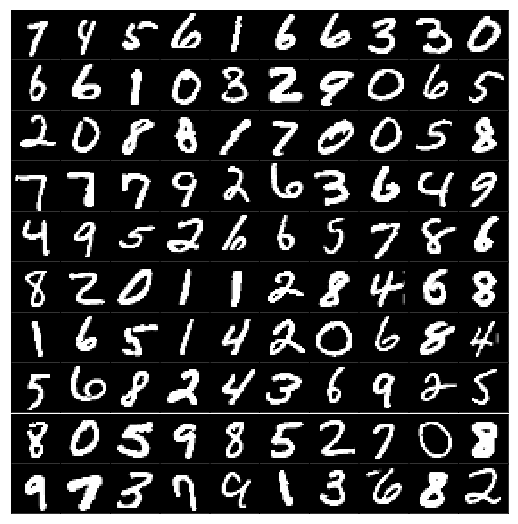

In [68]:
fig, axes = plt.subplots(10,10)
fig.subplots_adjust(left=0.1, hspace=0.01, wspace=0.01, right=1.25, bottom=0.05, top=1.8)
# use global min / max to ensure all weights are shown on the same scale
for pz, ax in zip(sample, axes.ravel()):
    #print(pz.shape)
    ax.matshow(pz.reshape(28, 28), cmap=plt.cm.gray, vmin=.5 * vmin,
               vmax=.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

In [69]:
L=nn_clf.get_layer(index=1)

In [70]:
wts=L.get_weights()[0]
print(wts.shape)
wmin, wmax = wts.min(), wts.max()
#idx=np.random.randint(0,wts.shape[1],25)

(784, 1024)


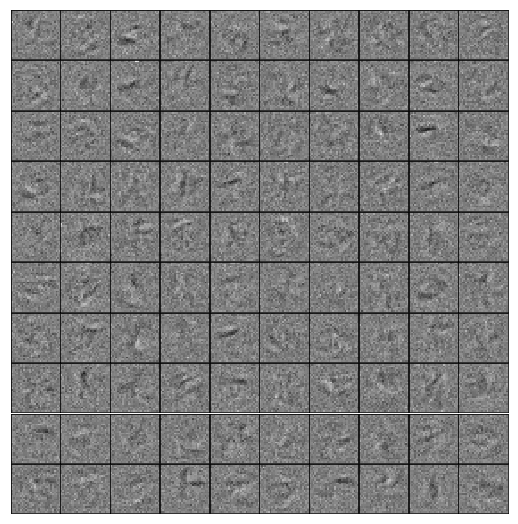

In [71]:
fig, axes = plt.subplots(10,10)
fig.subplots_adjust(left=0.1, hspace=0.01, wspace=0.01, right=1.25, bottom=0.05, top=1.8)
# use global min / max to ensure all weights are shown on the same scale
for pz, ax in zip(wts.transpose()[:100], axes.ravel()):
    ax.matshow(pz.reshape(28, 28), cmap=plt.cm.gray, vmin=.95 * wmin,
               vmax=.95 * wmax)
    ax.set_xticks(())
    ax.set_yticks(())
plt.show()

### Convolutonal NN

In [17]:
# Lenet-5 - keras example
from keras.layers.core import Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
img_rows, img_cols, img_depth = 28, 28, 1
in_shape = (img_rows, img_cols, img_depth)

def cnet_model():
    # create model
    model = Sequential()
    # For an explanation on conv layers see http://cs231n.github.io/convolutional-networks/#conv
    # By default the stride/subsample is 1 and there is no zero-padding.
    # If you want zero-padding add a ZeroPadding layer or, if stride is 1 use border_mode="same"
    model.add(Conv2D(32, (3, 3), activation = 'relu', input_shape=in_shape, padding='same', init='he_normal'))
    model.add(Conv2D(32, (3, 3), activation = 'relu', padding='same', init='he_normal'))
    model.add(BatchNormalization(axis=1))

    # For an explanation on pooling layers see http://cs231n.github.io/convolutional-networks/#pool
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation = 'relu', input_shape=in_shape, padding='same', init='he_normal'))
    model.add(Conv2D(64, (3, 3), activation = 'relu', padding='same', init='he_normal'))
    model.add(BatchNormalization(axis=1))

    # For an explanation on pooling layers see http://cs231n.github.io/convolutional-networks/#pool
    #model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the 3D output to 1D tensor for a fully connected layer to accept the input
    model.add(Flatten())
    
    model.add(Dense(512, kernel_initializer='normal', activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    #model.add(Dense(144, kernel_initializer='normal', activation='relu'))
    #model.add(Dropout(0.2))
    #model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='softmax'))
    # Compile model
    # For a multi-class classification problem
    model.compile(optimizer='adamax',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    return model

def schedule(n):
    if n<3:
        return 0.1
    else:
        return 0.01
    #else:
    #    return 0.001

In [24]:
cnn_clf= cnet_model()
cnn_clf.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 196)               2458820   
_________________________________________________________________
batch_normalization_3 (Batch (None, 196)               784       
_________________________________________________________________
dropout_7 (Dropout)          (None, 196)               0         
__________

In [20]:
# Train the model, iterating on the data in batches of 32 samples

# Train the model, iterating on the data in batches of 32 samples
with tf.device('/gpu:0'):
    cnn_clf.fit(data, one_hot_labels, callbacks=[keras.callbacks.LearningRateScheduler(schedule)], epochs=30, batch_size=128 )
    cnn_clf.fit(data, one_hot_labels, callbacks=[keras.callbacks.LearningRateScheduler(schedule)], epochs=5, batch_size=512 )

Epoch 1/5
60000/60000 [==============================] - 6s 108us/step - loss: 0.0355 - acc: 0.9900

In [21]:
score = cnn_clf.evaluate(X_test, keras.utils.to_categorical(y_val, num_classes=10), batch_size=256)
print(score)

10000/10000 [==============================] - 1s 68us/step
[0.028229700327595492, 0.99319999999999997]


In [22]:
yn_pred=cnn_clf.predict_classes(X_test)
yn_pred.shape

(10000,)

In [23]:
# Evaluate the prediction
print( "Evaluating results..." )
print("Precision: \t{:.4f}".format(metrics.precision_score(y_val, yn_pred, average='weighted')))
print("Recall: \t{:.4f}".format(metrics.recall_score(y_val, yn_pred, average='weighted')))
print("F1 score: \t{:.4f}".format(metrics.f1_score(y_val, yn_pred, average='weighted')))
#print("Mean acc. score: \t{:.4f}".format(clf2.score(preprocessing.scale(X_val), y_val)))

Evaluating results...
Precision: 	0.9932
Recall: 	0.9932
F1 score: 	0.9932


In [75]:
import tensorflow as tf

In [76]:
# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(sess.run(c))

[[ 22.  28.]
 [ 49.  64.]]


### References
1. (https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/) using the MNIST dataset.